In [1]:
from tqdm.notebook import trange, tqdm
import os
import json

import numpy as np
import pandas as pd
import swifter
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

os.chdir("..")

In [2]:
from src.utils import BETA_STR, LAMBDA_STR
from src.config import Ns, betas, halflife_vals, regularization_vals
from src.subjects_data import read_all, preprocess_data

In [3]:
subjects_order = [
    'AT',
    'CK',
    'ES',
    'EW',
    'GG',
    'HLA',
    'IG',
    'LV',
    'MH',
    'MN',
    'MZ',
    'RS',
    'SG',
    'SM',
    'SN',
    'YF',
    'ZD'
    ]

In [18]:
PATH = os.path.join(os.path.expanduser("~"), "proj_university\seminar-bci\subject_data")

In [19]:
data = read_all(PATH)
data = preprocess_data(data)

  0%|          | 0/17 [00:00<?, ?it/s]

Exception in HLA:
All arrays must be of the same length


# Features

In [6]:
from sklearn.linear_model import LinearRegression

In [7]:
from sklearn.metrics import r2_score

In [8]:
np.argmin([6.6,1,-7,3])

2

In [9]:
def get_regression_features(block, ma_halflife):
    ma_t_minus_one = block.ewm(
        halflife=ma_halflife, adjust=False).mean().shift(1).dropna() # shift caused dropping a value
    out_cols = {}
    out_cols['x1'] = block * ma_t_minus_one
    out_cols['x2'] = (1-block) * ma_t_minus_one
    out_cols['x3'] = block
    features = pd.DataFrame.from_dict(out_cols).dropna()
    return features

def fit_decay_to_signal(block, auc, halflife_vals=halflife_vals, regularization_vals=regularization_vals):
    mse_heatmap = np.empty((len(halflife_vals), len(regularization_vals)))
    y = auc.iloc[1:]   # we need t-1 for making explained variables
    for i, h in enumerate(tqdm(halflife_vals, desc="halflife", leave=False)):
        features = get_regression_features(block, ma_halflife=h)
        param_grid = {'alpha':regularization_vals}
        cv_search = GridSearchCV(Ridge(random_state=123, solver='svd'), param_grid, cv=5, 
            scoring='neg_mean_squared_error', n_jobs=-1, verbose=False)
        cv_search.fit(features, y)
        mse_heatmap[i, :] = cv_search.cv_results_["mean_test_score"]*-1    # sklearn implementation of scoring
    return mse_heatmap

def fit_only_h(block, auc, halflife_vals=halflife_vals):
    scores = list()
    y = auc.iloc[1:]   # we need t-1 for making explained variables
    for i, h in enumerate(tqdm(halflife_vals, desc="halflife", leave=False)):
        features = get_regression_features(block, ma_halflife=h)
        reg = LinearRegression()
        reg.fit(features, y)
        pred = reg.predict(features)
        scores.append(r2_score(y, pred))
    return halflife_vals[np.argmin(scores)]

def fit_lambda_given_h(block, auc, h, regularization_vals=regularization_vals):
    y = auc.iloc[1:]   # we need t-1 for making explained variables
    features = get_regression_features(block, ma_halflife=h)
    param_grid = {'alpha':regularization_vals}
    cv_search = GridSearchCV(Ridge(random_state=123, solver='svd'), param_grid, cv=5, 
            scoring='neg_mean_squared_error', n_jobs=-1, verbose=False)
    cv_search.fit(features, y)
    return cv_search.best_params_["alpha"]

In [10]:
data

,block,prob,auc,name,trial,N,beta_ind,beta,normal_factor,auc_normal
0,1.0,0.4,555.212952,AT,0,42,19,100.0,157.457016,3.526124
1,0.0,0.4,68.801247,AT,1,42,19,100.0,157.457016,0.436953
2,1.0,0.4,-13.266733,AT,2,42,19,100.0,157.457016,-0.084256
3,0.0,0.4,39.751682,AT,3,42,19,100.0,157.457016,0.252461
4,1.0,0.4,268.541901,AT,4,42,19,100.0,157.457016,1.705493
...,...,...,...,...,...,...,...,...,...,...
1195,0.0,0.2,52.913177,ZD,1195,16,19,100.0,299.316681,0.176780
1196,0.0,0.2,747.545715,ZD,1196,16,19,100.0,299.316681,2.497508
1197,0.0,0.2,-263.217987,ZD,1197,16,19,100.0,299.316681,-0.879396
1198,0.0,0.2,87.987183,ZD,1198,16,19,100.0,299.316681,0.293960


In [11]:
d_maps = dict()
for name in tqdm(data["name"].unique()):
    block = data.loc[data["name"]==name, "block"]
    auc_normal = data.loc[data["name"]==name, "auc_normal"]
    try:
        d_maps[name] = fit_decay_to_signal(block, auc_normal)
    except ValueError as e:
        print(f"{name}: {str(e)}")

  0%|          | 0/16 [00:00<?, ?it/s]

halflife:   0%|          | 0/50 [00:00<?, ?it/s]

halflife:   0%|          | 0/50 [00:00<?, ?it/s]

CK: Input contains NaN, infinity or a value too large for dtype('float64').


c:\users\yuvfr\appdata\local\programs\python\python38\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
  warnings.warn(


halflife:   0%|          | 0/50 [00:00<?, ?it/s]

halflife:   0%|          | 0/50 [00:00<?, ?it/s]

halflife:   0%|          | 0/50 [00:00<?, ?it/s]

GG: Input contains NaN, infinity or a value too large for dtype('float64').


c:\users\yuvfr\appdata\local\programs\python\python38\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
  warnings.warn(


halflife:   0%|          | 0/50 [00:00<?, ?it/s]

halflife:   0%|          | 0/50 [00:00<?, ?it/s]

halflife:   0%|          | 0/50 [00:00<?, ?it/s]

halflife:   0%|          | 0/50 [00:00<?, ?it/s]

halflife:   0%|          | 0/50 [00:00<?, ?it/s]

MZ: Input contains NaN, infinity or a value too large for dtype('float64').


c:\users\yuvfr\appdata\local\programs\python\python38\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
  warnings.warn(


halflife:   0%|          | 0/50 [00:00<?, ?it/s]

halflife:   0%|          | 0/50 [00:00<?, ?it/s]

halflife:   0%|          | 0/50 [00:00<?, ?it/s]

halflife:   0%|          | 0/50 [00:00<?, ?it/s]

halflife:   0%|          | 0/50 [00:00<?, ?it/s]

halflife:   0%|          | 0/50 [00:00<?, ?it/s]

ZD: Input contains NaN, infinity or a value too large for dtype('float64').


c:\users\yuvfr\appdata\local\programs\python\python38\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
  warnings.warn(


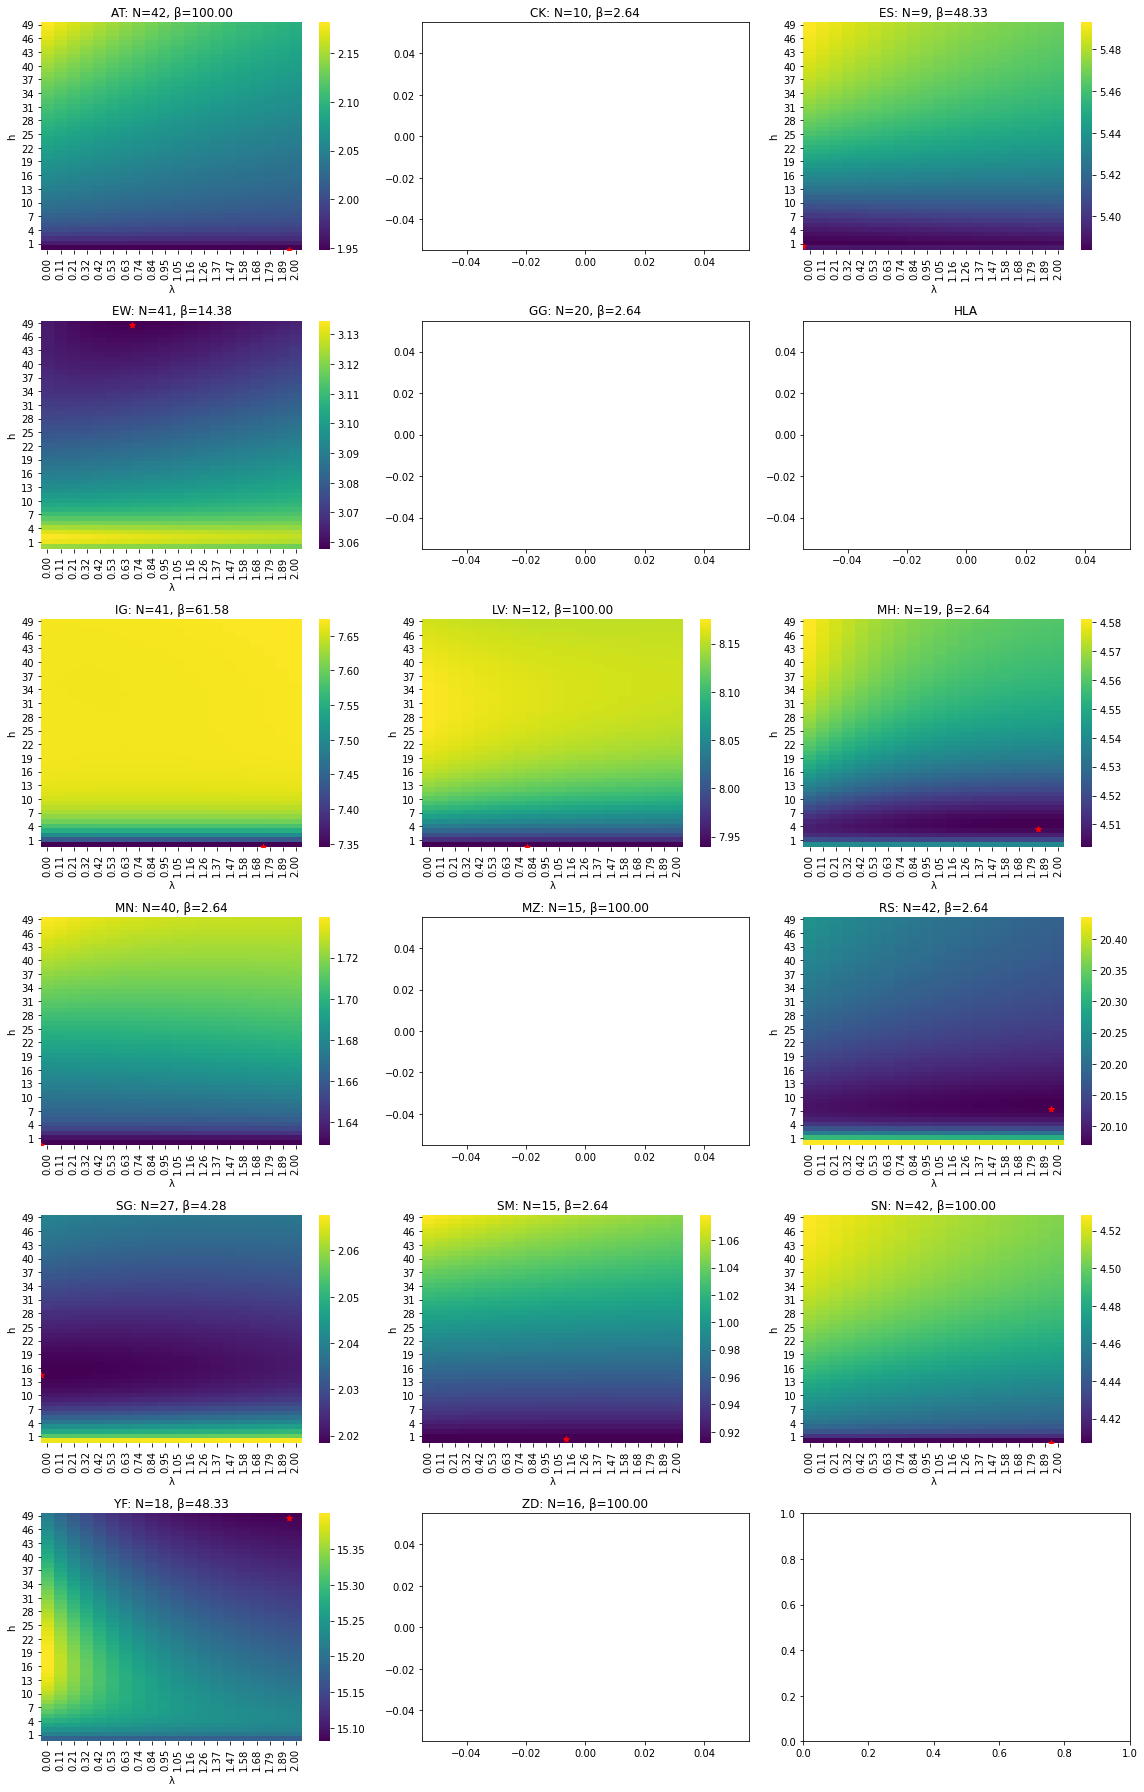

In [12]:
fig, axs = plt.subplots(6, 3, figsize=(16,25))
# plt.subplots_adjust()

for i, name in enumerate(subjects_order): # for subjects to appear in a known order
    mse_heatmap = d_maps.get(name)
    
    # plot
    ax = axs[i // 3, i % 3]
    if mse_heatmap is None: # subject doesn't have decay model
        ax.plot()
    else:
        sns.heatmap(
            pd.DataFrame(
                mse_heatmap[::-1], index=np.arange(len(mse_heatmap))[::-1], columns=[f"{l:.2f}" for l in regularization_vals]
            ).rename_axis(index="h", columns=LAMBDA_STR), 
            cmap="viridis", ax=ax)
        
        # plot best    
        best_h_idx, best_lambda_idx = np.where(mse_heatmap == mse_heatmap.min())
        ax.scatter(best_lambda_idx, 50-best_h_idx, c="r", marker="*")

    
    # mention N and beta
    try:
        N = data.loc[data["name"]==name, "N"][0]
        beta = data.loc[data["name"]==name, "beta"][0]
        title = f'{name}: N={N}, {BETA_STR}={beta:.2f}'
    except KeyError:
        title = name
    ax.set_title(title)

fig.tight_layout()
plt.show()

Compare two different approaches of fitting h and lambda:
1. fit regression for every combination (after block splitting), and than find the combination that minimizes RMSE.
2. fit regression for every halflife on whole block, find the optimal one by r2 score, than split block and find optimal lambda for that halflife (lambda that minimizes RMSE).

In [13]:
d_comparison = dict()
for name in tqdm(data["name"].unique()):
    block = data.loc[data["name"]==name, "block"]
    auc_normal = data.loc[data["name"]==name, "auc_normal"]
    try:
        mse_heatmap = d_maps[name]
        best_h_idx, best_lambda_idx = np.where(mse_heatmap == mse_heatmap.min())
        best_h_decay_model = int(halflife_vals[best_h_idx].item())
        best_l_decay_model = regularization_vals[best_lambda_idx].item()
        best_h_without_lambda = int(fit_only_h(block, auc_normal))
        best_lambda_based_comparison = fit_lambda_given_h(block, auc_normal, 
                                                 h=best_h_without_lambda, regularization_vals=regularization_vals)
        d_comparison[name] = {"combination": {"h": best_h_decay_model, "lambda": best_l_decay_model}, 
                     "separately": {"h": best_h_without_lambda, "lambda" :best_lambda_based_comparison}}
    except (ValueError, KeyError) as e:
        print(f"{name}: {str(e)}")

  0%|          | 0/16 [00:00<?, ?it/s]

halflife:   0%|          | 0/50 [00:00<?, ?it/s]

CK: 'CK'


halflife:   0%|          | 0/50 [00:00<?, ?it/s]

halflife:   0%|          | 0/50 [00:00<?, ?it/s]

GG: 'GG'


halflife:   0%|          | 0/50 [00:00<?, ?it/s]

halflife:   0%|          | 0/50 [00:00<?, ?it/s]

halflife:   0%|          | 0/50 [00:00<?, ?it/s]

halflife:   0%|          | 0/50 [00:00<?, ?it/s]

MZ: 'MZ'


halflife:   0%|          | 0/50 [00:00<?, ?it/s]

halflife:   0%|          | 0/50 [00:00<?, ?it/s]

halflife:   0%|          | 0/50 [00:00<?, ?it/s]

halflife:   0%|          | 0/50 [00:00<?, ?it/s]

halflife:   0%|          | 0/50 [00:00<?, ?it/s]

ZD: 'ZD'


In [14]:


print(json.dumps(d_comparison, indent=2))

{
  "AT": {
    "combination": {
      "h": 1,
      "lambda": 2.0
    },
    "separately": {
      "h": 15,
      "lambda": 2.0
    }
  },
  "ES": {
    "combination": {
      "h": 2,
      "lambda": 0.0
    },
    "separately": {
      "h": 28,
      "lambda": 2.0
    }
  },
  "EW": {
    "combination": {
      "h": 50,
      "lambda": 0.7368421052631579
    },
    "separately": {
      "h": 7,
      "lambda": 0.5263157894736842
    }
  },
  "IG": {
    "combination": {
      "h": 1,
      "lambda": 1.789473684210526
    },
    "separately": {
      "h": 34,
      "lambda": 0.42105263157894735
    }
  },
  "LV": {
    "combination": {
      "h": 1,
      "lambda": 0.8421052631578947
    },
    "separately": {
      "h": 50,
      "lambda": 1.4736842105263157
    }
  },
  "MH": {
    "combination": {
      "h": 5,
      "lambda": 1.894736842105263
    },
    "separately": {
      "h": 50,
      "lambda": 2.0
    }
  },
  "MN": {
    "combination": {
      "h": 1,
      "lambda": 0.0
 